# Compétition Kaggle : classification de lésions cutanées
##### Ivan Khodakov

### Sommaire

1. Analyse des images et compréhension des enjeux
2. Classification par utilisation de CNN
3. Extraction de Features et classification par features

## 1. Analyse des images et compréhension des enjeux

### 1.librairies

In [1]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import pandas as pd

### 2. Metadata

Je souhaite en premier lieu, me renseigner à propos des images donnés. A quoi ressemblent-elles ? Quel est leur dimension ? Sont-elles segmentés ? Quelle est la taille du jeux de données ? Les classes sont-elles équitablement répartis ?
Je ne peux commencer mon travail de classification sans avoir le maximum d'information à ce sujet.
J'ai donc commencé par observer la metadata.

In [3]:
metadata_test_path = "metadata/metadataTest.csv"
metadata_train_path = "metadata/metadataTrain.csv"
metadata_test = pd.read_csv(metadata_test_path)
metadata_train = pd.read_csv(metadata_train_path)
metadata_train.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,2,male,30.0,NaN
1,ISIC_0071222,8,male,85.0,lower extremity
2,ISIC_0069434,3,male,85.0,head/neck
3,ISIC_0062098,1,male,55.0,head/neck
4,ISIC_0057224,8,female,45.0,lower extremity


In [4]:
metadata_test.head()

,ID,SEX,AGE,POSITION
0,ISIC_0055289,female,50.0,lower extremity
1,ISIC_0062682,male,65.0,lower extremity
2,ISIC_0057706,female,75.0,NaN
3,ISIC_0031702,male,70.0,head/neck
4,ISIC_0069272,male,60.0,lower extremity


Je me suis ensuite demandé si les classes étaient également répartis.

In [5]:
class_counts_train = metadata_train["CLASS"].value_counts()
print(class_counts_train)

2    9657
1    3391
3    2492
5    1968
4     650
8     471
7     190
6     179
Name: CLASS, dtype: int64


Ce n'est pas le cas, je prends donc note qu'il sera nécessaire de rééchantilloner les classes ou d'appliquer des poids à mes méthodes de classification.

### 3. Visualisation des images

Voici mon premier code, il m'a permis de visualiser les images et d'obtenir certaines informations utiles à la suite de mon travail comme leur segmentation et leur dimension (grâce à un dataframe).

In [3]:
# Chemin du dossier contenant les images
dossier_train = 'Train'
dossier_test = 'Test'

# Listes pour stocker les différentes catégories d'images
train_images = []
train_segmentations = []
test_images = []
test_segmentations = []

image_heights = []
image_widths = []
names = []
types = []
needsegmentation = []
segmented = False

# Parcourir le dossier et lire chaque fichier
for fichier in os.listdir(dossier_train):
    chemin_image = os.path.join(dossier_train, fichier)
    
    # Vérifier si le fichier est une image segmentée
    if "_seg" in fichier:
        segmentation = io.imread(chemin_image)
        train_segmentations.append(segmentation)
        nom_image = fichier.replace('.png', '')
        height, width = segmentation.shape
        image_heights.append(height)
        image_widths.append(width)
        names.append(nom_image+'_seg')
        types.append('train')
        needsegmentation.append('segmentation')
        segmented = True


        
    else:
        # Lire l'image non segmentée
        image = io.imread(chemin_image)
        train_images.append(image)
        height, width, _ = image.shape
        image_heights.append(height)
        image_widths.append(width)
        nom_image = fichier.replace('.jpg', '')
        names.append(nom_image)
        types.append('train')
        if segmented :
            needsegmentation.append('segmented')
        else:
            needsegmentation.append('not segmented')
        segmented = False

for fichier in os.listdir(dossier_test):
    chemin_image = os.path.join(dossier_test, fichier)
    
    # Vérifier si le fichier est une image segmentée
    if "_seg" in fichier:
        segmentation = io.imread(chemin_image)
        train_segmentations.append(segmentation)
        nom_image = fichier.replace('.png', '')
        height, width = segmentation.shape
        image_heights.append(height)
        image_widths.append(width)
        names.append(nom_image+'_seg')
        types.append('test')
        needsegmentation.append('segmentation')
        segmented = True


        
    else:
        # Lire l'image non segmentée
        image = io.imread(chemin_image)
        train_images.append(image)
        height, width, _ = image.shape
        image_heights.append(height)
        image_widths.append(width)
        nom_image = fichier.replace('.jpg', '')
        names.append(nom_image)
        types.append('test')
        if segmented :
            needsegmentation.append('segmented')
        else:
            needsegmentation.append('not segmented')
        segmented = False
# Créer un DataFrame pour stocker les informations sur les images
df = pd.DataFrame({'name': names, 'type': types, 'height': image_heights, 'width': image_widths, 'needsegmentation': needsegmentation})


Tout d'abord, affichons 5 images pour visualiser le type d'images dont il s'agit.

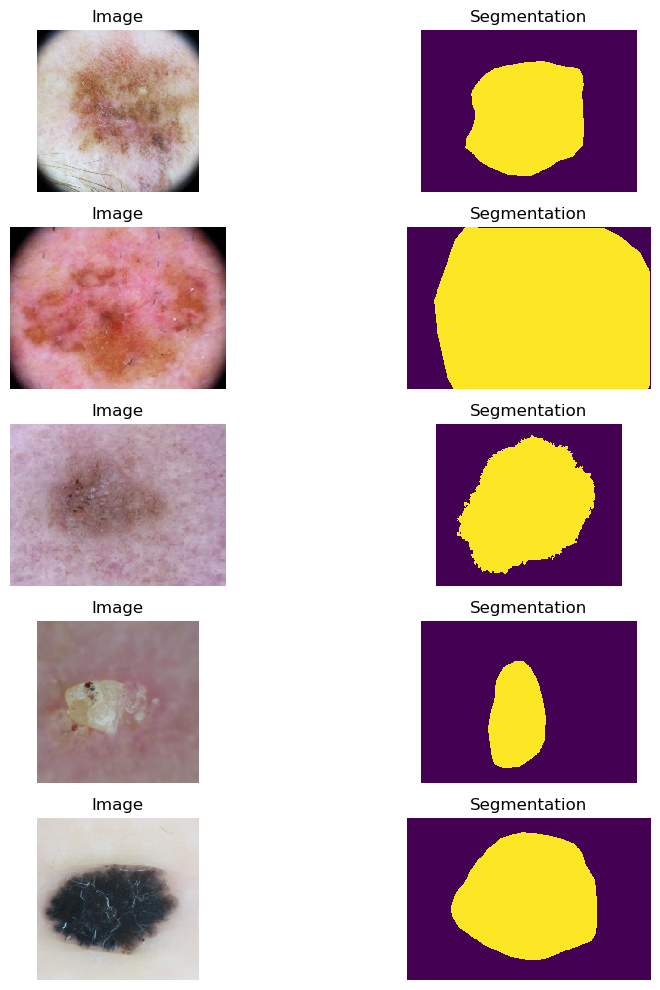

In [4]:
num_images = 5
fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

for i in range(num_images):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    
    ax1.imshow(train_images[i])
    ax1.axis('off')
    ax1.set_title('Image')
    
    ax2.imshow(train_segmentations[i])
    ax2.axis('off')
    ax2.set_title('Segmentation')

plt.tight_layout()
plt.show()

In [5]:
df.head()

,name,type,height,width,needsegmentation
0,ISIC_0009902_seg_seg,train,384,512,segmentation
1,ISIC_0070364,train,512,512,segmented
2,ISIC_0026188,train,225,300,not segmented
3,ISIC_0031376,train,225,300,not segmented
4,ISIC_0071524,train,512,512,not segmented


Je me suis ensuite demandé quelle était la proportion des dimensionnements des images. Je voulais savoir si il pouvait etre judicieux de redimmensionner seulement quelques images si le reste était au même format.

In [6]:
image_counts_by_size = df.groupby(['width', 'height']).size().reset_index(name='count')
# Triez les résultats par ordre décroissant du nombre d'images
image_counts_by_size_sorted = image_counts_by_size.sort_values('count', ascending=False)

print(image_counts_by_size_sorted[0:10])

    width  height  count
84    512     512  12415
1     300     225  10016
57    512     340   2253
71    512     384   1504
58    512     341    410
59    512     342    360
56    512     339    166
9     384     288    131
70    512     382    115
17    460     401    103


Je me rends compte que les images ont des dimensions assez variés. Il sera donc utile de toutes les redimensioner au même format.
Je me demande ensuite quel est la proportion d'images segmentées. Est-il possible par exemple d'entrainer un réseau de neuronne à la segmentation d'image ?

In [7]:
image_count_by_segmentation = df.groupby(['type','needsegmentation']).size().reset_index(name='count')
print(image_count_by_segmentation)

    type needsegmentation  count
0   test    not segmented   5736
1   test     segmentation    648
2   test        segmented    597
3  train    not segmented  17173
4  train     segmentation   1946
5  train        segmented   1825


Les images segmentés semblent assez nombreuses, c'est une bonne nouvelle.

## 2.Classification par utilisation de CNN

En commençant mon travail, j'étais motivé par l'obention de résultats rapidement. J'étais déterminé à pouvoir importer sur Kaggle des feuilles de score.
J'ai pensé que la manière la plus simple de commencer était de classifier les images en utilisation les réseaux de neuronnes par convolution. J'avais d'hors et déjà lu les articles de recherche mis à disposition, et il me semblait que le procédé d'obtention de features était plus complexe. Il fallait commencer par segmenter, puis par extraire des features spécifiques. Cela semblait bien plus long.

### 1. Librairies et GPU

In [8]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from torchvision import transforms
import cv2
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
from torchvision import models
import copy

Pour commencer, je me suis connecté aux GPU de Télécom Paris et j'ai vérifié leur disponibilité. Cela fonctionne ! 

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


### 2. Création de Datasets

Je me suis beaucoup renseigné pour optimiser mon utilisation de CNN. Pour cela, j'ai regardé de nombreuses vidéos sur internet, j'ai aussi zieuté des dépots github de classification d'images.
J'ai vite compris qu'il était nécessaire que je crée des datasets pour mes images.

#### 2.1 Ma classe TrainingDataset

Mon code a deux spécificités : mon utilisation de nombreuses transformations, et le calcul des poids des classes.
- J'ai utilisé de nombreuses transformations pour éviter l'overfitting de mon CNN. J'avais au départ appliquer les transformations dans l'initialisation. Cependant, en les plaçant dans "get", il est possible d'appliquer des transformation qui puisse être différente à chaque époque lorsqu'elles sont aléatoires. J'ai donc modifié mon code pour combattre au mieux l'overfitting.
- J'ai calculé le poids de chaque classe pour ensuite pouvoir m'en servir dans la loss. Cette technique revient à réchantilloner les classes pour qu'elles aient toutes le même poids.

In [10]:
preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TrainingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=preprocess, under_sample_coeff=1.0):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        class_counts = np.zeros(8)
        for i in range(len(self.annotations)):
            label = self.annotations.iloc[i, 1]
            class_counts[label-1] += 1

        self.class_weights = len(self.annotations)/(8*class_counts)

        
        self.images = []
        self.labels = []
        for idx in tqdm(range(len(self.annotations)), desc="Loading Images"):
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.jpg')
            img = Image.open(img_name).convert('RGB')
            # img = cv2.imread(img_name)
            # grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # kernel = cv2.getStructuringElement(1, (9, 9))
            # blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
            # bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
            # ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
            # img = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
            self.images.append(img)
            self.labels.append(self.annotations.iloc[idx, 1])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.images[idx]
        img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [11]:
dataset = TrainingDataset(csv_file ='metadata/metadataTrain.csv', root_dir='Train')

Loading Images: 100%|██████████| 18998/18998 [03:35<00:00, 88.26it/s] 


#### 2.2 Ma classe TestDataset

La classe TestDataset est la classe qui permets de charger les images du dossier test. La différence avec la classe TrainingDataSet est qu'elle n'applique pas de transforms aléatoires et qu'elle renvoie le nom de l'image dans le "get". C'est utile pour pouvoir ensuite créer un fichier csv pour la compétition Kaggle.

In [12]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=preprocess):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.ids = self.annotations.iloc[:, 0]
        self.images = []

        for idx in tqdm(range(len(self.annotations)), desc="Loading Images"):
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.jpg')
            img = Image.open(img_name).convert('RGB')
            # img = cv2.imread(img_name)
            # grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # kernel = cv2.getStructuringElement(1, (9, 9))
            # blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
            # bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
            # ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
            # img = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
            transformed_img = self.transform(img)
            self.images.append(transformed_img)
            
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self.images[idx]
        id = self.ids[idx]

        return img,id

In [13]:
test_dataset = TestDataset(csv_file ='metadata/metadataTest.csv', root_dir='Test')


Loading Images: 100%|██████████| 6333/6333 [01:18<00:00, 80.55it/s] 


#### 2.3 Visualisation des images après les transformations appliqués pendant le dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

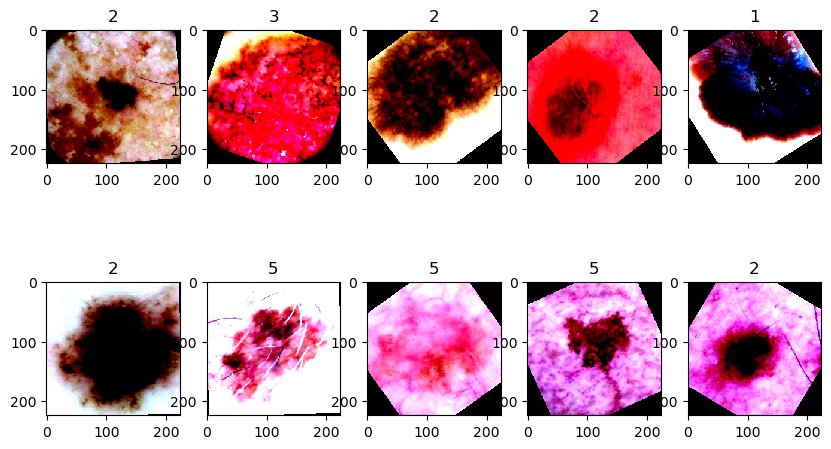

In [14]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,len(dataset))
    image, label = dataset[rand_ind]
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image,cmap='gray')
    plt.title(label)

#### 2.4 Création d'un set de validation et d'un set d'entrainement.

J'ai créé un set de validation et un set d'entrainement pour pouvoir trouver le modèle idéal avant loss du set de validation se mette à augmenter lors de l'entraînement.
J'ai décidé de ne pas appliquer des transformations aléatoires à mon set de validation parce que ce n'est pas nécessaire. En effet , le modèle ne peut pas overfitté le set de validation.

In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
new_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_dataset.transform = new_transforms

#### 2.5 Création des loader

J'ai choisi un batch_size = 64, car cela me permettait d'obtenir de bons résultats.

In [16]:
dataloader = DataLoader(train_dataset, batch_size=64, shuffle = True)
valdataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


###  3. Les modèles utilisés.

J'ai commencé par utiliser un réseau de neuronnes assez simple pour obtenir mes premiers résultats.
Les résultats étaient encouragants. En me renseignant, j'ai compris par la suite que les modèles les plus efficaces étaient les modèles préentrainés.

In [17]:
class SkinLesionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(SkinLesionClassifier, self).__init__()
        
        # Couches de convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Couches entièrement connectées
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Couches de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout pour la régularisation
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Aplatir les features map avant les couches entièrement connectées
        x = x.view(-1, 256 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x


Le deuxième modèle que j'ai utilisé est un resnet50. Je l'ai choisi après m'être renseigné parce qu'il me semblait être un bon compromis entre son efficacité et sa complexité.

In [18]:
class SkinLesionClassifier2(nn.Module):
    def __init__(self, num_classes=8):
        super(SkinLesionClassifier2, self).__init__()
        self.resnet = models.resnet50(pretrained='DEFAULT')

        # Modifying the last fully connected layer to output 8 classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)


    def forward(self, x):
        return self.resnet(x)

### 4. Mes choix pour l'entrainement 

#### 4.1 Loss, optimizer etc...

Les résultats les plus convaincants que j'ai pu obtenir sont ceux avec les choix observables ci-dessous. 
J'ai essayé différentes autres options :
- Choisir un learning rate différent pour la partie du modèle préentrainé que pour la dernière couche du réseau.
- Utiliser un scheduler, ou un scaler. Je n'ai pas observé des résultats signfificativement différents.

In [99]:

skinLesionClassifier = SkinLesionClassifier2()
skinLesionClassifier = skinLesionClassifier.to(device)

class_weights = torch.tensor(dataset.class_weights,dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
# optimizer = torch.optim.Adam([{'params': skinLesionClassifier.resnet.fc.parameters(),'lr': 0.0001}],lr=0.00001)
# optimizer = optim.SGD(skinLesionClassifier.parameters(), lr=0.001, momentum=0.5)
# scheduler = ReduceLROnPlateau(optimizer, patience=1,  verbose=True)
optimizer = torch.optim.Adam(skinLesionClassifier.parameters(),lr=0.0001)

# scaler = torch.cuda.amp.GradScaler()
print(skinLesionClassifier)


tensor([ 0.7003,  0.2459,  0.9529,  3.6535,  1.2067, 13.2668, 12.4987,  5.0419],
       device='cuda:0')
SkinLesionClassifier2(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

#### 4.2 Early Stopping

J'ai implémenté l'early stopping pour trouver le modèle idéal avant lequel la loss du validation set ne se mette à augmenter. L'early stopping me permets d'accéder au modèle idéal avant que l'overfitting ne se fasse sentir.

In [20]:
class EarlyStopping:
    def __init__(self, patience):
        self.done = False
        self.patience = patience
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss>val_loss:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                model.load_state_dict(self.best_model)
                torch.save(model.load_state_dict, "best_model.pth")
                return True
            
        print(self.status)
        return False

### 5. L'entraînement

#### 5.1 Les fonctions utiles à l'entrainement

Une fonction déjà vu en TP :

In [21]:
def vector_to_class(x):
    # Instantiate the softmax module
    softmax = torch.nn.Softmax(dim=1)
    
    # Apply softmax to the input tensor
    prob = softmax(x)
    
    # Get the class with the highest probability using argmax
    y = torch.argmax(prob, dim=1)
    
    return y


J'ai repris les poids donnés sur Kaggle pour calculer la précision à chaque époque.

In [22]:
weights = torch.tensor([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745],dtype=torch.float32).to(device)
def check_model(loader, model, criterion):
    num_correct = 0
    weighted_correct = 0
    num_samples = 0
    loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y -=1
            scores = skinLesionClassifier(x)
            predictions = vector_to_class(scores)

            correct_predictions = (predictions == y)
    
            weighted_correct_predictions = correct_predictions * weights[y]
    
            weighted_correct += weighted_correct_predictions.sum()
            loss+= criterion(scores,y).item()
            num_correct += (predictions == y).sum()
            num_samples += predictions.shape[0]
        accuracy =weighted_correct/num_samples
        loss/= num_samples

        print(f'Got {num_correct} / {num_samples} with validation accuracy {float(accuracy)} and with loss {loss}')
    return loss, accuracy



Ma fonction d'entraînement pour une époque

In [23]:
def train(loader, model, optimizer, loss):
    train_accuracy = 0
    num_correct = 0
    num_samples = 0
    global_loss = 0
    for batch_idx, (data, targets) in enumerate(tqdm(loader)):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        targets-=1
        #forward
        scores = model(data)
        predictions = vector_to_class(scores)
        #train accuracy and loss computation
        correct_predictions = (predictions == targets)
        weighted_correct_predictions = correct_predictions * weights[targets]
        train_accuracy += weighted_correct_predictions.sum()
        num_correct += (predictions == targets).sum()
        num_samples += predictions.shape[0]
        batch_loss = loss(scores, targets)
        global_loss+= batch_loss.item()

        # backward
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    train_accuracy/=num_samples
    global_loss/=num_samples
    print(f'Got {num_correct} / {num_samples} with train accuracy {train_accuracy} and with loss {global_loss}')
    return global_loss,train_accuracy


#### 5.2 Lancer l'entraînement.

In [24]:
# check_accuracy(valdataloader, skinLesionClassifier)
num_epoch = 10
es = EarlyStopping(patience = 4)
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch = 0
done = False
while epoch <num_epoch and not done :
        epoch+=1

        #training part
        skinLesionClassifier.train()
        train_loss, train_accuracy = train(dataloader, skinLesionClassifier, optimizer, criterion)
        train_losses.append(train_loss), train_accuracies.append(train_accuracy)

        #evaluation part
        skinLesionClassifier.eval()
        val_loss, val_accuracy = check_model(valdataloader,skinLesionClassifier, criterion)
        val_accuracies.append(val_accuracy), val_losses.append(val_loss)
        
        # early stopping 
        done = es(skinLesionClassifier,val_loss)


  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 238/238 [05:50<00:00,  1.47s/it]


Got 8017 / 15198 with train accuracy 0.5138848423957825 and with loss 0.021104720791384864
Got 2064 / 3800 with validation accuracy 0.5762558579444885 and with loss 0.01822928897644344



100%|██████████| 238/238 [05:50<00:00,  1.47s/it]


Got 9146 / 15198 with train accuracy 0.6158356666564941 and with loss 0.01688039890126596
Got 2161 / 3800 with validation accuracy 0.6172289252281189 and with loss 0.01780887500235909
Improvement found, counter reset to 0


100%|██████████| 238/238 [05:55<00:00,  1.49s/it]


Got 9607 / 15198 with train accuracy 0.6575015783309937 and with loss 0.015024482511677135
Got 2282 / 3800 with validation accuracy 0.5710556507110596 and with loss 0.018600567281246184
No improvement in the last 1 epochs


100%|██████████| 238/238 [05:57<00:00,  1.50s/it]


Got 9909 / 15198 with train accuracy 0.6941297054290771 and with loss 0.013775223357487014
Got 2228 / 3800 with validation accuracy 0.6195763349533081 and with loss 0.01692052761190816
Improvement found, counter reset to 0


100%|██████████| 238/238 [05:55<00:00,  1.50s/it]


Got 10213 / 15198 with train accuracy 0.7080849409103394 and with loss 0.01292549262142194
Got 2442 / 3800 with validation accuracy 0.6671391129493713 and with loss 0.015563665785287556
Improvement found, counter reset to 0


100%|██████████| 238/238 [05:56<00:00,  1.50s/it]


Got 10556 / 15198 with train accuracy 0.7416887283325195 and with loss 0.011279260716888211
Got 2713 / 3800 with validation accuracy 0.6713136434555054 and with loss 0.015709624925726338
No improvement in the last 1 epochs


100%|██████████| 238/238 [05:55<00:00,  1.49s/it]


Got 10928 / 15198 with train accuracy 0.7674798369407654 and with loss 0.010137205334349138
Got 2311 / 3800 with validation accuracy 0.6435585618019104 and with loss 0.01714478666845121
No improvement in the last 2 epochs


100%|██████████| 238/238 [05:54<00:00,  1.49s/it]


Got 10860 / 15198 with train accuracy 0.7679527401924133 and with loss 0.010400998884948527
Got 2623 / 3800 with validation accuracy 0.6900317072868347 and with loss 0.015304333512720309
Improvement found, counter reset to 0


100%|██████████| 238/238 [05:54<00:00,  1.49s/it]


Got 10885 / 15198 with train accuracy 0.7736149430274963 and with loss 0.010043936508402164
Got 2525 / 3800 with validation accuracy 0.6635378003120422 and with loss 0.016621521240786502
No improvement in the last 1 epochs


100%|██████████| 238/238 [05:55<00:00,  1.49s/it]


Got 11361 / 15198 with train accuracy 0.8021625280380249 and with loss 0.008871555400923815
Got 2591 / 3800 with validation accuracy 0.7004154920578003 and with loss 0.015103727037969389
Improvement found, counter reset to 0


### 6. Analyse des résultats et code de soumission csv

#### 6.1 Analyse visuelle

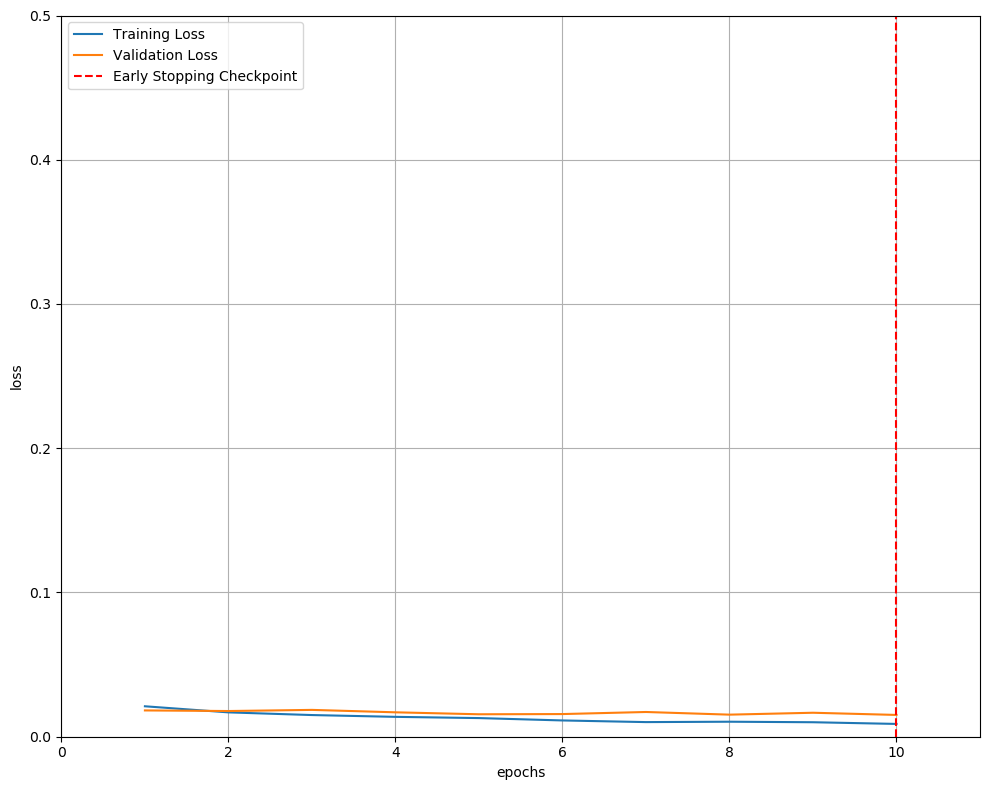

In [26]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### 6.2 Soumission csv

J'obtenais au plus 0.7 en submission Kaggle grâce à cet entraînement.

In [27]:
def make_prediction(model, dataloader):
    preds = []
    model.eval()
    ids = []
    with tqdm(test_dataloader,unit = "batch") as tepoch :
        for imgs, id in tepoch :
            imgs = imgs.to(device)
            ids.extend(id)
            with torch.no_grad():
                pred = vector_to_class(model(imgs))
                preds.extend(pred.tolist())
    df = pd.DataFrame({'ID': ids, 'CLASS': np.array(preds)+1})
    df.to_csv('submissions/submissionCNN.csv', index=False)
    print("Done with predictions")
make_prediction(skinLesionClassifier,test_dataloader)

100%|██████████| 99/99 [00:40<00:00,  2.46batch/s]

Done with predictions


## 3. Extraction de features et classification par features

### 1. Librairies

In [2]:
from customDataSet import CustomDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.morphology.convex_hull import convex_hull_image
import cv2
import pandas as pd
import os
from tqdm import tqdm
from numpy.random import shuffle
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim



### 2. Segmentation

J'avais pensé au départ à segmenter mes images en utilisant les segmentations déjà disponibles grâce à un réseau de neuronnes. J'ai changé d'avis par la suite en pensant qu'utiliser chan-vese serait plus simple.

#### 2.1 Enlever les poils

Les articles de recherche lus préconisaient d'enlever les poils apparents sur les images avant de les segmenter: ils pouvaient être source d'erreurs. J'ai trouvé un algorithme qui les enlevait grâce au dépot github suivant: https://github.com/fazlerabbi2248/Dull_razor_algorithm

In [3]:
def dull_razor(img) :        
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    img = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return img

#### 2.1 Segmentation avec Chan-Vese

En segmentant avec Chan-Vese, je me suis rendu compte que j'obtenais systématique des reliquats sur les bords de l'image du masque binaire. Pour enlever ces reliquats, je me suis servi d'un masque circulaire que j'applique au masque de chan-vese pour enlever cet effet de bord

In [4]:
def create_circular_mask(h, w, radius=None):

    center = [int(w/2), int(h/2)]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

J'ai eu alors un autre problème. La segmentation était souvent bonne, mais l'élément à segmenter était en blanc ou en noir sur le masque. C'était problématique pour la suite de mon travail. <br>
Pour palier à ça, je me suis servi de deux masques candidats, de tel manière que l'élément à segmenter soit en blanc sur un des deux masques. <br>
Pour choisir le bon masque candidat parmi les deux, je me suis servi du fait que le masque recherché a moins de pixels blancs que l'autre après application d'une enveloppe convexe (cela ne se vérifie pas toujours en pratique si l'on n'applique pas d'enveloppe convexe, il est donc nécessaire de le faire).

In [5]:
def segmentation(img, radius = None):

    image_f = img_as_float(img)
    grey_image = rgb2gray(image_f)
    h,w = grey_image.shape
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(int(w/2), int(h/2), w-int(w/2), h-int(h/2))
    init_ls   = checkerboard_level_set((h,w), 6)

    chan_vese= morphological_chan_vese(grey_image, 5, init_level_set=init_ls, smoothing=10).astype(np.uint8)
    circular_mask=create_circular_mask(h, w,radius)
    candidate_mask_1 = chan_vese.copy() * circular_mask
    candidate_mask_2 = (np.invert(chan_vese.copy()) + 2) * circular_mask

    convex_hull_1 = convex_hull_image(candidate_mask_1)
    convex_hull_2 = convex_hull_image(candidate_mask_2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    if (np.sum(convex_hull_1) < np.sum(convex_hull_2)):
        mask = cv2.morphologyEx(candidate_mask_1, cv2.MORPH_OPEN, kernel)
    else :
        mask = cv2.morphologyEx(candidate_mask_2, cv2.MORPH_OPEN, kernel)
    if np.sum(mask)<1000:
        mask = circular_mask
        mask = mask.astype(np.uint8) * 255
    return mask

J'ai aussi codé une fonction, dont je ne me sers pas dans la suite, mais qui permets d'enregistrer les images segmentés dans un autre dossier.

In [6]:
def segment_images(input_folder, output_folder, csv_file):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    annotations = pd.read_csv(csv_file)
    image_files = os.listdir(input_folder)

    for idx in tqdm(range(len(annotations)), desc="Loading Segmentations"):
        img_name = os.path.join(input_folder, annotations.iloc[idx, 0])
        image = cv2.imread(img_name+'.jpg')
        image = dull_razor(image)
        segmented_image = segmentation(image)
        # Enregistrer l'image segmentée dans le dossier de sortie
        output_path = os.path.join(output_folder,img_name + '_seg.jpg')
        cv2.imwrite(output_path, segmented_image)


### 3. Extraire les features ABCD des images segmentés

Pour extraire les features grâce au masque trouvé, j'ai d'abord lu attentivement les articles de recherche à ce sujet. J'ai ensuite chercher sur github des codes pour calculer les features ABCD (asymmetry, border structure, variegated color, and dermatoscopical structures).
Je me suis inspiré du github pour calculer les features suivantes  : https://github.com/anindox8/Multi-Color-Space-Features-for-Dermatoscopy-Classification/

#### 3.1 ABCD features

In [7]:

def color_moments(image):
    image = np.float64(image)    
    mean_0 = np.mean(image[:,:,0])
    mean_1 = np.mean(image[:,:,1])
    mean_2 = np.mean(image[:,:,2])
    std_0  = np.std(image[:,:,0])
    std_1  = np.std(image[:,:,1])
    std_2  = np.std(image[:,:,2])
    skew_0 = skew(image[:,:,0].reshape(-1))
    skew_1 = skew(image[:,:,1].reshape(-1))
    skew_2 = skew(image[:,:,2].reshape(-1))
    kurt_0 = kurtosis(image[:,:,0].reshape(-1))
    kurt_1 = kurtosis(image[:,:,1].reshape(-1))
    kurt_2 = kurtosis(image[:,:,2].reshape(-1))
    return mean_0, std_0, skew_0, kurt_0, mean_1, std_1, skew_1, kurt_1, mean_2, std_2, skew_2, kurt_2

In [8]:
def abcd_features(image,mask=None):    
    # Color Spaces: I/O ------------------------------------------------------------------------------------------------------------------------------------------------------
    img_RGB = image

    img_GL= cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_HSV= cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    circa_mask= create_circular_mask(image.shape[0], image.shape[1], radius = 100).astype(bool)
    
    masked_lesion_GL= np.ma.array(np.multiply(img_GL,    circa_mask)  ,mask=~circa_mask)
    masked_lesion_RGB= np.ma.array(np.multiply(img_RGB,   np.dstack((circa_mask,circa_mask,circa_mask))), mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_HSV= np.ma.array(np.multiply(img_HSV,   np.dstack((circa_mask,circa_mask,circa_mask))), mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    mean_R, std_R, skew_R, kurt_R, mean_G,  std_G,  skew_G,  kurt_G,  mean_B,  std_B,  skew_B,  kurt_B   = color_moments(masked_lesion_RGB)
    mean_H, std_H, skew_H, kurt_H, mean_S,  std_S,  skew_S,  kurt_S,  mean_V,  std_V,  skew_V,  kurt_V   = color_moments(masked_lesion_HSV)
    
    features = [mean_R, std_R, skew_R, kurt_R,mean_G, std_G, skew_G, kurt_G,mean_B, std_B, skew_B, kurt_B,
                mean_H, std_H, skew_H, kurt_H,mean_S, std_S, skew_S, kurt_S,mean_V, std_V, skew_V, kurt_V]

    return features

#### 3.2 Extraire les features

In [9]:

def extract_train_features(csv_file, root_dir) :
    annotations = pd.read_csv(csv_file)
    features = []
    labels = []
    for idx in tqdm(range(len(annotations)), desc="Loading Images"):
        img_name = os.path.join(root_dir, annotations.iloc[idx, 0] + '.jpg')
        img = cv2.imread(img_name)
        img = cv2.resize(img, (224, 224))
        img = dull_razor(img)
        mask = segmentation(img)
        features_img = abcd_features(img, mask)
        features.append(features_img)
        labels.append(annotations.iloc[idx, 1])
    return features,labels


Pour les images tests, analogue à la TestDataset.

In [10]:
def extract_test_features(csv_file, root_dir) :
    annotations = pd.read_csv(csv_file)
    features = []
    ids = []
    for idx in tqdm(range(len(annotations)), desc="Loading Images"):
        img_name = os.path.join(root_dir, annotations.iloc[idx, 0] + '.jpg')
        img = cv2.imread(img_name)
        img = cv2.resize(img, (224, 224))
        img = dull_razor(img)
        mask = segmentation(img)
        features_img = abcd_features(img, mask)
        features.append(features_img)
        ids.append(annotations.iloc[idx, 0])
    return features,ids

In [11]:
train_features, labels = extract_train_features(csv_file ="metadata/metadataTrain.csv", root_dir='Train')

Loading Images:   0%|          | 0/18998 [00:00<?, ?it/s]

Loading Images:  57%|█████▋    | 10736/18998 [57:44<43:37,  3.16it/s]  /tmp/ipykernel_3665399/647671247.py:16: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  convex_hull_2 = convex_hull_image(candidate_mask_2)
Loading Images: 100%|██████████| 18998/18998 [1:50:36<00:00,  2.86it/s]  


In [12]:
test_features, ids = extract_test_features(csv_file ="metadata/metadataTest.csv", root_dir='Test')

Loading Images:   1%|          | 39/6333 [00:17<46:52,  2.24it/s]

Loading Images: 100%|██████████| 6333/6333 [45:58<00:00,  2.30it/s]  


#### 4. Classification

#### 4.1 Preprocess

In [13]:
X_train = np.array(train_features)
y_train = np.array(labels)
N = len(train_features)
indexes = np.arange(0,N)
shuffle(indexes)
X_train = X_train[indexes]
y_train = y_train[indexes]

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(test_features)

#### 4.2 Random Forest

J'ai choisi de travailler par cross-validation pour trouver les paramètres optimaux. Les poids donnés sont ceux donnés sur Kaggle.

In [15]:

# CV over Random Forest
weight = np.array([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745])
RF=RandomForestClassifier(random_state=0, class_weight=dict(enumerate(weight)))
p_grid_RF = {'n_estimators': [10,15,20,25,30],'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'],'criterion' : ['entropy', 'gini']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train-1)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Random Forest train score :",grid_RF.score(X_train, y_train-1))
print("Best params: {}".format(grid_RF.best_params_))

In [ ]:
best_model = grid_RF.best_estimator_
predictions = best_model.predict(X_test)

In [ ]:
predictions = best_model.predict(X_test)
df = pd.DataFrame({'ID': ids, 'CLASS': np.array(predictions)+1})
df.to_csv('submissions/submissionRF.csv', index=False)

J'obtenais pour la random forest 0.35 de précision en moyenne par soumission Kaggle. Il est certainement possible d'améliorer ce score en extrayant plus de features

### 5. MLP pour la classification

#### 5.1 Préparation à l'entrainement

In [ ]:
def vector_to_class(x):
    # Instantiate the softmax module
    softmax = torch.nn.Softmax(dim=1)
    
    # Apply softmax to the input tensor
    prob = softmax(x)
    
    # Get the class with the highest probability using argmax
    y = torch.argmax(prob, dim=1)
    
    return y


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### 5.2 Mon modèle

J'ai pris un modèle assez simple de réseau de neuronnes, ici la complexité du modèle importe moins au vu du nombre de features.

In [ ]:
class MLP(nn.Module):

  def __init__(self, n_input, n_hidden, n_output):
    super(MLP,self).__init__()

    self.linear1 = nn.Linear(n_input, n_hidden)
    self.activation1 = nn.ReLU()
    self.dropout = nn.Dropout(0.2) 
    self.linear2 = nn.Linear(n_hidden, n_output)
    self.activation2 = nn.Sigmoid()  # Sigmoid for binary classification

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation1(x)
    x = self.dropout(x)  # Applying dropout
    x = self.linear2(x)
    x = self.activation2(x)
    return x

# Initialisation du modèle
model = MLP(24, 50, 8).to(device)

# Définition de la fonction de perte et de l'optimiseur
weights = torch.tensor([0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745],dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Conversion des données en tenseurs PyTorch
features_tensor = torch.tensor(X_train,dtype=torch.float32)
labels_tensor = torch.tensor(y_train,dtype=torch.long)-1

#### 5.3 L'entraînement

In [ ]:
# Entraînement du modèle
num_epochs = 10
batch_size = 32
model.train()
for epoch in range(num_epochs):
    for i in range(0, N, batch_size):
        inputs = features_tensor[i:i+batch_size].to(device)
        targets = labels_tensor[i:i+batch_size].to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé!")

# Ici, pour l'exemple, on utilise les mêmes données d'entraînement
model.eval()
with torch.no_grad():
    features_tensor = features_tensor.to(device)
    labels_tensor = labels_tensor.to(device)
    outputs = model(features_tensor)
    predicted = vector_to_class(outputs)
    correct_predictions = (predicted == labels_tensor)

    weighted_correct = correct_predictions * weights[labels_tensor]
    accuracy =weighted_correct.sum()/N

    print(f'Accuracy: {accuracy}')

Epoch [1/10], Loss: 1.6086
Epoch [2/10], Loss: 1.6007
Epoch [3/10], Loss: 1.5848
Epoch [4/10], Loss: 1.5277
Epoch [5/10], Loss: 1.5671
Epoch [6/10], Loss: 1.5446
Epoch [7/10], Loss: 1.5827
Epoch [8/10], Loss: 1.5297
Epoch [9/10], Loss: 1.5592
Epoch [10/10], Loss: 1.5108
Entraînement terminé!
Accuracy: 0.2967660129070282


### 5.4 La prédiction

Il est possible d'optimiser les résultats en augmentant le nombre de features. Je n'ai pas pris l'entropy par exemple, qui est pourtant souvent utilisée.

In [ ]:

torch_test_features = torch.tensor(test_features, dtype = torch.float32).to(device)
def make_prediction(model, features, ids):
    model.eval()
    with torch.no_grad():
        predicted = vector_to_class(model(features)).to('cpu')
        df = pd.DataFrame({'ID': ids, 'CLASS': predicted.numpy()+1})
        df.to_csv('submissions/submissionMLP.csv', index=False)
        print("Done with predictions")
make_prediction(model,torch_test_features, ids)

Done with predictions


####